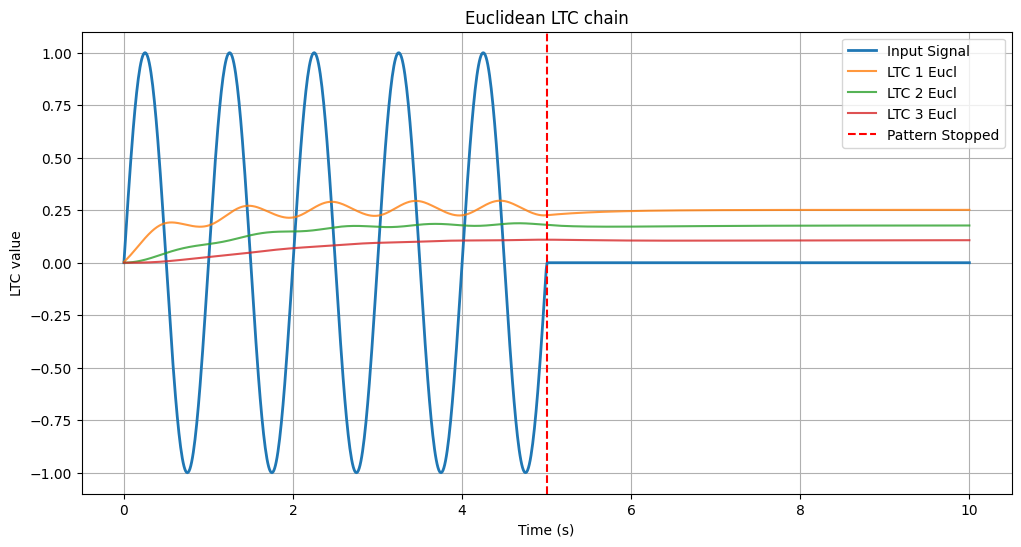

[Euclidean] LTC 1 did not forget within the sim time.
[Euclidean] LTC 2 did not forget within the sim time.
[Euclidean] LTC 3 did not forget within the sim time.


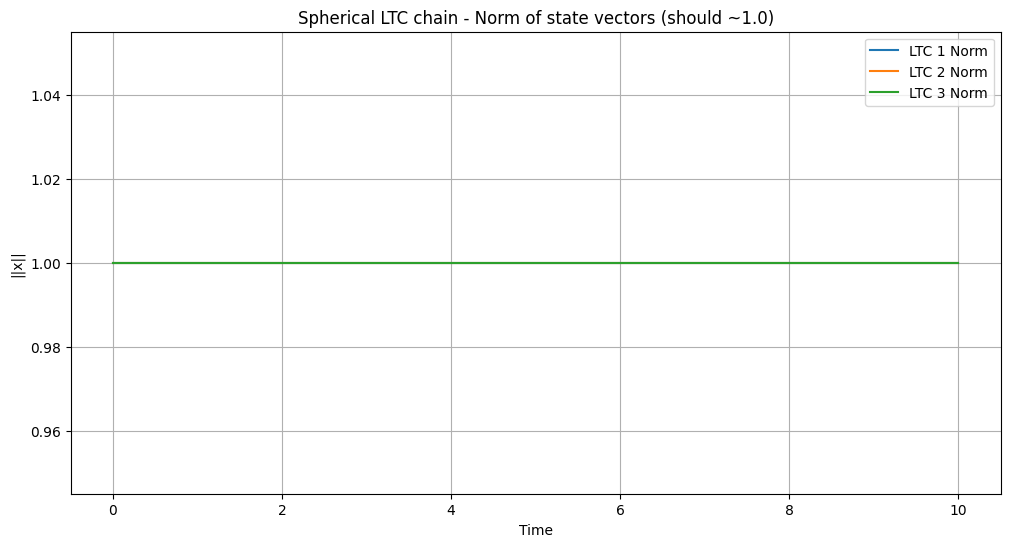

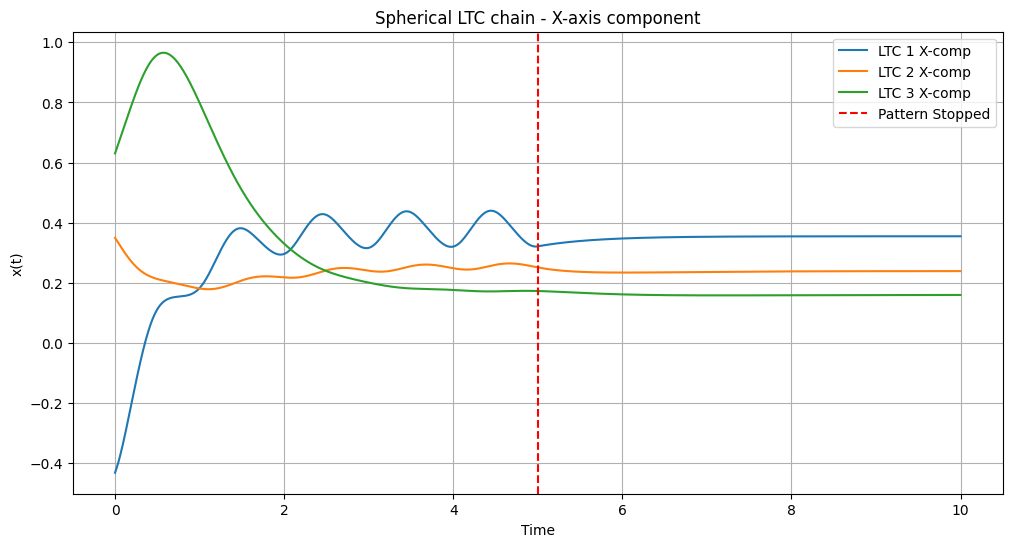

Done. You now have side-by-side Euclidean LTC (Hassan's approach) vs. a toy Spherical LTC chain.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# PART A: Parameters
# -----------------------
num_ltc = 3         # Number of LTC neurons in chain
tau = 1.0           # Time constant of LTC
gleak = 0.5         # Leak conductance
cm_t = 1.0          # Membrane capacitance
dt = 0.01           # Time step
total_time = 10.0   # Total simulation time
pattern_time = 5.0  # Duration of feeding the pattern
threshold = 0.05    # Threshold to determine "forgetting"

num_steps = int(total_time / dt)
pattern_steps = int(pattern_time / dt)

# Create time array and input signal
t = np.linspace(0, total_time, num_steps)
freq = 1.0
input_signal = np.zeros(num_steps)
for i in range(pattern_steps):
    input_signal[i] = np.sin(2 * np.pi * freq * t[i])

# Sigmoid function
def sigmoid(x, mu=0.5, sigma=1.0):
    return 1 / (1 + np.exp(-sigma * (x - mu)))

# -----------------------
# PART B: Euclidean LTC chain (Hassan's original style)
# -----------------------

def run_chain_ltc_euclidean(num_ltc, num_steps, dt, tau, gleak, cm_t, pattern_steps,
                            input_signal, threshold):
    # States for each LTC neuron
    h_vals = np.zeros((num_ltc, num_steps))
    # Current state
    h = np.zeros(num_ltc)
    # Dynamic weights
    weights = np.random.uniform(0.5, 1.5, num_ltc)  # random example

    # Simulate
    for step_i in range(num_steps):
        # input to first neuron
        u = sigmoid(input_signal[step_i])
        # LTC update for neuron 0
        dh0 = (1.0 / tau) * (u - h[0]) - gleak * h[0]
        h[0] += dt * dh0 / cm_t
        
        # chain updates for subsequent neurons
        for j in range(1, num_ltc):
            dh = (1.0 / tau) * (weights[j-1] * h[j-1] - h[j]) - gleak * h[j]
            h[j] += dt * dh / cm_t
        
        # store
        h_vals[:, step_i] = h
    
    # find forgetting times
    forgetting_times = []
    for i in range(num_ltc):
        forget_time = None
        for idx in range(pattern_steps, num_steps):
            if abs(h_vals[i, idx]) < threshold:
                forget_time = t[idx] - t[pattern_steps]
                break
        forgetting_times.append(forget_time)
    return h_vals, forgetting_times

# -----------------------
# PART C: Minimal Non-Euclidean LTC approach (Spherical) for comparison
# (We'll do a separate chain or single-ltc example, not the entire chain, to keep it short).
# -----------------------

def normalize_sphere(vec):
    """Normalize a vector in R^3 to the unit sphere."""
    norm = np.linalg.norm(vec)
    if norm < 1e-12:
        return vec
    return vec / norm

def log_map_sphere(p, q):
    """
    Log_{p}(q) for unit sphere in R^3.
    (As in prior sketches.)
    """
    p_n = normalize_sphere(p)
    q_n = normalize_sphere(q)
    dot_ = np.clip(np.dot(p_n, q_n), -1.0, 1.0)
    angle = np.arccos(dot_)
    if angle < 1e-12:
        return np.zeros_like(p)
    perp = q_n - dot_ * p_n
    perp_norm = np.linalg.norm(perp)
    if perp_norm < 1e-12:
        return np.zeros_like(p)
    dir_ = perp / perp_norm
    return dir_ * angle

def exp_map_sphere(p, v):
    """
    Exp_{p}(v) for unit sphere in R^3.
    """
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-12:
        return p
    p_n = normalize_sphere(p)
    dir_ = v / norm_v
    # remove any component along p
    dir_ = dir_ - np.dot(dir_, p_n) * p_n
    dir_ = normalize_sphere(dir_)
    new_point = np.cos(norm_v)*p_n + np.sin(norm_v)*dir_
    return normalize_sphere(new_point)

def ltc_update_sphere(x, u, dt, tau, gleak=0.5):
    """
    Non-Euclidean LTC update on sphere + a 'leak' (demo).
    We'll interpret 'leak' as a mild push of x towards some baseline?
    For a simpler analogy, let's just do the LTC part ignoring leak first.
    """
    alpha = dt/tau
    # log map
    v = log_map_sphere(x, u)
    # scale
    v_scaled = alpha * v
    # exponentiate
    x_new = exp_map_sphere(x, v_scaled)
    # Optionally handle a 'leak' by pulling x_new slightly toward baseline [0,0,1] or something
    # For demonstration, let's do a small step:
    baseline = np.array([0,0,1.0])  # "rest" direction on sphere
    # blend x_new with baseline in tangent space
    # This is a hacky demonstration:
    leak_alpha = gleak*dt
    v_leak = log_map_sphere(x_new, baseline)
    x_final = exp_map_sphere(x_new, leak_alpha*v_leak)
    return x_final

def run_chain_ltc_sphere(num_ltc, num_steps, dt, tau, gleak, input_signal, pattern_time):
    """
    We'll do a chain of LTC states in 3D, each on the sphere.
    We'll keep it simple: the first LTC sees input_signal as amplitude
    that shifts it from a baseline direction. Next LTC sees the prior LTC's position, etc.
    """
    # states is shape (num_ltc, 3, num_steps)
    states = np.zeros((num_ltc, 3, num_steps))
    # init random directions
    x = [normalize_sphere(np.random.randn(3)) for _ in range(num_ltc)]
    # random or fixed chain weights
    weights = np.random.uniform(0.5, 1.5, num_ltc)

    for step_i in range(num_steps):
        t_cur = step_i * dt
        # input for first LTC
        amp = sigmoid(input_signal[step_i])
        # We'll create a "target" for LTC 0 by rotating baseline [0,0,1] with amplitude
        baseline = np.array([0, 0, 1.0])
        # We do a small hack: if amp>0.5, tilt it toward x-axis
        target0 = baseline*(1-amp) + amp*np.array([1,0,0])
        target0 = normalize_sphere(target0)
        
        x[0] = ltc_update_sphere(x[0], target0, dt, tau, gleak=gleak)
        
        # chain updates
        for j in range(1, num_ltc):
            # interpret x[j-1] as the "input" for x[j]"
            x[j] = ltc_update_sphere(x[j], x[j-1], dt, tau, gleak=gleak)
        
        # store
        for j in range(num_ltc):
            states[j,:,step_i] = x[j]
    return states

# -----------------------
# PART D: Main Execution
# -----------------------
if __name__ == "__main__":
    # 1) Run Euclidean LTC
    h_vals_euc, forgetting_times = run_chain_ltc_euclidean(
        num_ltc, num_steps, dt, tau, gleak, cm_t,
        pattern_steps, input_signal, threshold
    )

    # 2) Run spherical LTC
    states_sphere = run_chain_ltc_sphere(
        num_ltc, num_steps, dt, tau, gleak,
        input_signal, pattern_time
    )
    # states_sphere shape => (num_ltc, 3, num_steps)

    # Plot Euclidean results
    plt.figure(figsize=(12,6))
    plt.plot(np.linspace(0,total_time,num_steps), input_signal, label='Input Signal', linewidth=2)

    for i in range(num_ltc):
        plt.plot(np.linspace(0,total_time,num_steps), h_vals_euc[i], label=f'LTC {i+1} Eucl', alpha=0.8)
    plt.axvline(pattern_time, color='r', linestyle='--', label='Pattern Stopped')
    plt.title("Euclidean LTC chain")
    plt.xlabel("Time (s)")
    plt.ylabel("LTC value")
    plt.grid(True)
    plt.legend()
    plt.show()

    for i in range(num_ltc):
        ft = forgetting_times[i]
        if ft is not None:
            print(f"[Euclidean] LTC {i+1} Time to forget: {ft:.2f}s")
        else:
            print(f"[Euclidean] LTC {i+1} did not forget within the sim time.")

    # Plot Spherical results
    # We'll just plot the norm (should remain close to 1) and maybe the x-projection
    time_axis = np.linspace(0,total_time,num_steps)
    plt.figure(figsize=(12,6))
    for i in range(num_ltc):
        # norm of state
        norm_vals = np.linalg.norm(states_sphere[i], axis=0)
        plt.plot(time_axis, norm_vals, label=f'LTC {i+1} Norm')

    plt.title("Spherical LTC chain - Norm of state vectors (should ~1.0)")
    plt.xlabel("Time")
    plt.ylabel("||x||")
    plt.legend()
    plt.grid(True)
    plt.show()

    # For a sense of "forgetting," we might track the x-axis component of the 3D vector
    plt.figure(figsize=(12,6))
    for i in range(num_ltc):
        x_axis_component = states_sphere[i,0,:]  # x-component
        plt.plot(time_axis, x_axis_component, label=f'LTC {i+1} X-comp')
    plt.axvline(pattern_time, color='r', linestyle='--', label='Pattern Stopped')
    plt.title("Spherical LTC chain - X-axis component")
    plt.xlabel("Time")
    plt.ylabel("x(t)")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Done. You now have side-by-side Euclidean LTC (Hassan's approach) vs. a toy Spherical LTC chain.")